<a href="https://colab.research.google.com/github/sruthiscodes/capstone/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install mne
!pip install pywavelets
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install scikit-learn
!pip install keras-tuner

import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
import os
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import keras_tuner as kt

In [24]:
np.random.seed(42)
subjects = range(1, 10)  # 9 subjects
runs = [4, 8, 12]

# Preprocessing parameters
samplingFreq = 160
lowFreq = 0.5
highFreq = 45
notchFreq = 60
tMin, tMax = 0, 4

In [25]:
def loadEEG(subject, runs):
    filePaths = eegbci.load_data(subject, runs)
    print(f"Loading data for subject {subject}")
    rawlist = []

    for file in filePaths:
        raw = read_raw_edf(file, preload=True)
        rawlist.append(raw)

    if len(rawlist) > 1:
        raw = mne.concatenate_raws(rawlist)
    else:
        raw = rawlist[0]

    rename_dict = {
        'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2', 'Fc4.': 'FC4', 'Fc6.': 'FC6',
        'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1', 'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6',
        'Cp5.': 'CP5', 'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4', 'Cp6.': 'CP6',
        'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7', 'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8',
        'F7..': 'F7', 'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2', 'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8',
        'Ft7.': 'FT7', 'Ft8.': 'FT8', 'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7', 'Tp8.': 'TP8',
        'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1', 'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
        'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8', 'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
    }
    raw.rename_channels(rename_dict)

    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    events, eventID = mne.events_from_annotations(raw)
    raw.filter(l_freq=lowFreq, h_freq=highFreq)
    raw.notch_filter(freqs=notchFreq)

    eventID = dict(T1=1, T2=2)
    epochs = mne.Epochs(raw, events, eventID, tmin=tMin, tmax=tMax, baseline=None, preload=True)
    return raw, epochs, events, eventID

In [26]:
allData = []
allLabels = []
# Process each subject
for subject in subjects:
    try:
        print(f"\n{'='*50}\nProcessing subject {subject}\n{'='*50}")
        raw, epochs, events, eventID = loadEEG(subject, runs)

        print(f"Subject {subject} data loaded successfully")
        print(f"Number of channels: {len(raw.ch_names)}")
        print(f"Number of epochs: {len(epochs)}")
        print(f"Sampling frequency: {raw.info['sfreq']} Hz")
        print(f"Duration: {raw.times.max()} seconds")

        # Extract raw epoched data and labels
        data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
        labels = epochs.events[:, -1]  # Shape: (n_epochs,)

        allData.append(data)
        allLabels.append(labels)

        print(f"Data shape for subject {subject}: {data.shape}")
        print(f"Labels: {np.unique(labels, return_counts=True)}")

    except Exception as e:
        print(f"Error processing subject {subject}: {e}")
        continue


Processing subject 1
Loading data for subject 1
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a on

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Subject 1 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Data shape for subject 1: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 2
Loading data for subject 2
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Subject 2 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 2: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 3
Loading data for subject 3
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Ann

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 3 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Data shape for subject 3: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 4
Loading data for subject 4
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Subject 4 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 4: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 5
Loading data for subject 5
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Not setting metadata
66 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 66 events and 641 original time points ...
0 bad epochs dropped
Subject 5 data loaded successfully
Number of channels: 64
Number of epochs: 66
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 5: (66, 64, 641)
Labels: (array([1, 2]), array([45, 21]))

Processing subject 6
Loading data for subject 6
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 69 events and 641 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Subject 6 data loaded successfully
Number of channels: 64
Number of epochs: 69
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 6: (69, 64, 641)
Labels: (array([1, 2]), array([45, 24]))

Processing subject 7
Loading data for subject 7
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Ann

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Not setting metadata
68 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 7 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Data shape for subject 7: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 8
Loading data for subject 8
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
67 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 67 events and 641 original time points ...
0 bad epochs dropped
Subject 8 data loaded successfully
Number of channels: 64
Number of epochs: 67
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 8: (67, 64, 641)
Labels: (array([1, 2]), array([45, 22]))

Processing subject 9
Loading data for subject 9
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 69 events and 641 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Subject 9 data loaded successfully
Number of channels: 64
Number of epochs: 69
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 9: (69, 64, 641)
Labels: (array([1, 2]), array([45, 24]))


In [29]:
X = np.concatenate(allData, axis=0)  # Shape: (total_epochs, n_channels, n_times)
y = np.concatenate(allLabels, axis=0)  # Shape: (total_epochs,)

# Standardize data per channel
n_channels = X.shape[1]
for c in range(n_channels):
    channel_data = X[:, c, :]
    mean_c = np.mean(channel_data)
    std_c = np.std(channel_data)
    if std_c > 0:  # Avoid division by zero
        X[:, c, :] = (channel_data - mean_c) / std_c

# Map labels to 0 and 1 (T1=1 -> 0, T2=2 -> 1)
y = y - 1


Unique labels: [0 1]
Label counts: [405 206]
Saved class distribution plot to ./eeg_data/class_distribution.png


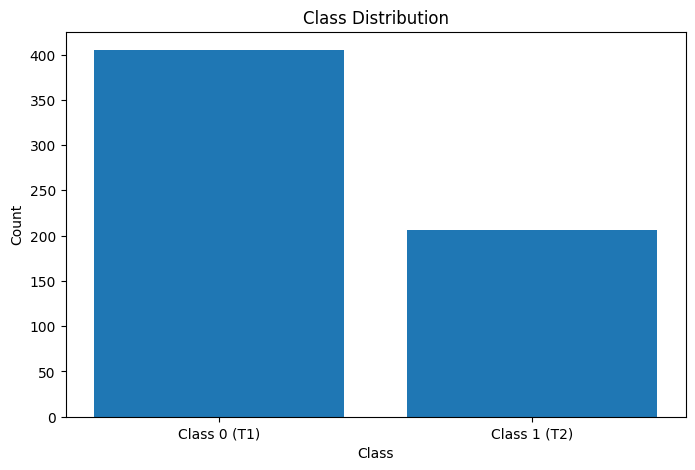

In [30]:
# Check class distribution
unique_labels, counts = np.unique(y, return_counts=True)
print(f"\nUnique labels: {unique_labels}")
print(f"Label counts: {counts}")
# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(['Class 0 (T1)', 'Class 1 (T2)'], counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
if not os.path.exists('./eeg_data'):
    os.makedirs('./eeg_data')
plt.savefig('./eeg_data/class_distribution.png')
print("Saved class distribution plot to ./eeg_data/class_distribution.png")
plt.show()

# Transpose X to match LSTM input shape (n_samples, n_timesteps, n_channels)
X = np.transpose(X, (0, 2, 1))  # Changes (n_epochs, n_channels, n_times) to (n_epochs, n_times, n_channels)

In [31]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")
# Reshape for LSTM (no need for X_train.shape[3] since it's 3D)
X_train_lstm = X_train  # Shape: (n_samples, n_timesteps, n_channels)
X_test_lstm = X_test    # Shape: (n_samples, n_timesteps, n_channels)


Class weights: {0: np.float64(0.7393939393939394), 1: np.float64(1.5443037974683544)}


In [32]:
# Step 1: LSTM Model for Temporal Features
def build_lstm_model(hp):
    model = models.Sequential()
    model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                          input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
                          return_sequences=False))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [33]:
# Tune LSTM hyperparameters with Hyperband
tuner_lstm = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Search for best hyperparameters
tuner_lstm.search(X_train_lstm, y_train, epochs=20, validation_data=(X_test_lstm, y_test),
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])
best_lstm_model = tuner_lstm.get_best_models(num_models=1)[0]
# Predict probabilities with LSTM
lstm_probs = best_lstm_model.predict(X_test_lstm)

Trial 30 Complete [00h 01m 12s]
val_accuracy: 0.6016260385513306

Best val_accuracy So Far: 0.6504064798355103
Total elapsed time: 00h 20m 23s
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


In [36]:
def build_cnn_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(filters=hp.Int('filters', min_value=16, max_value=64, step=16),
                            kernel_size=(3, 3),
                            activation='relu',
                            input_shape=(X_train.shape[1], X_train.shape[2], 1)))  # Added 1 for feature dimension
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [37]:
# Reshape X_train and X_test for CNN (add feature dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)  # Add a feature dimension
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)  # Add a feature dimension

In [39]:
# Tune CNN hyperparameters with Hyperband
tuner_cnn = kt.Hyperband(
    build_cnn_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='cnn_tuning'
)

# Search for best hyperparameters
tuner_cnn.search(X_train_cnn, y_train, epochs=20, validation_data=(X_test_cnn, y_test),
                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])
best_cnn_model = tuner_cnn.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 01m 37s]
val_accuracy: 0.7235772609710693

Best val_accuracy So Far: 0.772357702255249
Total elapsed time: 01h 19m 11s


In [40]:
# Predict probabilities with CNN
cnn_probs = best_cnn_model.predict(X_test_cnn)

# Step 3: Ensemble Predictions
# Ensemble by averaging probabilities
ensemble_probs = (lstm_probs + cnn_probs) / 2

# Convert probabilities to binary predictions
ensemble_preds = (ensemble_probs > 0.5).astype(int)

# Evaluate ensemble performance
accuracy = accuracy_score(y_test, ensemble_preds)
print(f"Ensemble Accuracy (Averaging): {accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
Ensemble Accuracy (Averaging): 0.7560975609756098


In [41]:
# Optional: Train a meta-learner (logistic regression) on the probabilities
meta_X_train = np.hstack((best_lstm_model.predict(X_train_lstm), best_cnn_model.predict(X_train_cnn)))
meta_X_test = np.hstack((lstm_probs, cnn_probs))
meta_model = LogisticRegression()
meta_model.fit(meta_X_train, y_train)
meta_preds = meta_model.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)
print(f"Meta-Learner Accuracy: {meta_accuracy}")

# Step 4: Optional Alternative with XGBoost for Spatial Features
def extract_spatial_features(X):
    n_samples, n_timesteps, n_channels = X.shape
    spatial_features = np.zeros((n_samples, n_channels * (n_channels - 1) // 2))
    idx = 0
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            spatial_features[:, idx] = np.mean(np.corrcoef(X[:, :, i], X[:, :, j])[0, 1])
            idx += 1
    return spatial_features

X_train_spatial = extract_spatial_features(X_train)
X_test_spatial = extract_spatial_features(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step
Meta-Learner Accuracy: 0.7642276422764228


In [42]:
# Train XGBoost on spatial features
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_spatial, y_train)

# Predict probabilities with XGBoost
xgb_probs = xgb_model.predict_proba(X_test_spatial)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:39:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [44]:
# Ensemble with LSTM
ensemble_probs_xgb = (lstm_probs.ravel() + xgb_probs) / 2  # Flatten lstm_probs
ensemble_preds_xgb = (ensemble_probs_xgb > 0.5).astype(int)
accuracy_xgb = accuracy_score(y_test, ensemble_preds_xgb)
print(f"Ensemble Accuracy with XGBoost: {accuracy_xgb}")

Ensemble Accuracy with XGBoost: 0.6097560975609756
